In [1]:
import json
import math
import os
import pickle
from datetime import datetime

import boto3
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import tifffile
from shapely.geometry import shape
from sklearn.mixture import GaussianMixture
from sklearn.svm import SVC
from snappy import ProductIO, GPF, jpy, ProgressMonitor

try:
    import consts
except ImportError:
    import test_consts as consts

matplotlib.use('TkAgg')
plt.ioff()
s3 = boto3.resource('s3')
os.makedirs(consts.PATH, exist_ok=True)
HashMap = jpy.get_type('java.util.HashMap')
num_clusters = 29

def download_file(s3_bucket, s3_key, local_path):
    try:
        s3_bucket.download_file(s3_key, local_path)
        return local_path
    except Exception as e:
        print(e)
            
def overlay_mask(image, title=None, cloud_mask=None, shadow_mask=None, figsize=(10, 10)):
    """
    Utility function for plotting RGB images with binary mask overlayed.
    """
    plt.figure(title, figsize=figsize)
    plt.imshow(image)
    plt.tight_layout()
    plt.axis("off")
    if cloud_mask is not None:
        cloud_image = np.zeros((cloud_mask.shape[0], cloud_mask.shape[1], 4), dtype=np.uint8)
        cloud_image[cloud_mask == True] = np.asarray([255, 255, 0, 100], dtype=np.uint8)
        plt.imshow(cloud_image)
        plt.tight_layout()
        plt.axis("off")
    if shadow_mask is not None:
        cloud_image = np.zeros((shadow_mask.shape[0], shadow_mask.shape[1], 4), dtype=np.uint8)
        cloud_image[shadow_mask == True] = np.asarray([255, 204, 229, 100], dtype=np.uint8)
        plt.imshow(cloud_image)
        plt.tight_layout()
        plt.axis("off")

def glcm(product_path):
    """
    https://forum.step.esa.int/t/python-codes-of-glcm-for-texture-feature-extraction/2568
    
    modified to be up-to-date with SNAP 7.0
    
    parameters:     
        angleStr=<string>                           Sets parameter 'angleStr' to <string>.
                                                    Value must be one of '0', '45', '90', '135', 'ALL'.
                                                    DEFAULT value is 'ALL'.
    
        displacement=<int>                          Pixel displacement
                                                    Valid interval is [1, 8].
                                                    DEFAULT value is '4'.
    
        outputASM=<boolean>                         Output Angular Second Moment
                                                    DEFAULT value is 'true'.
    
        outputContrast=<boolean>                    Output Contrast
                                                    DEFAULT value is 'true'.
    
        outputCorrelation=<boolean>                 Output GLCM Correlation
                                                    DEFAULT value is 'true'.
    
        outputDissimilarity=<boolean>               Output Dissimilarity
                                                    DEFAULT value is 'true'.
    
        outputEnergy=<boolean>                      Output Energy
                                                    DEFAULT value is 'true'.
    
        outputEntropy=<boolean>                     Output Entropy
                                                    DEFAULT value is 'true'.
    
        outputHomogeneity=<boolean>                 Output Homogeneity
                                                    DEFAULT value is 'true'.
    
        outputMAX=<boolean>                         Output Maximum Probability
                                                    DEFAULT value is 'true'.
    
        outputMean=<boolean>                        Output GLCM Mean
                                                    DEFAULT value is 'true'.
    
        outputVariance=<boolean>                    Output GLCM Variance
                                                    DEFAULT value is 'true'.
    
        quantizationLevelsStr=<string>              Sets parameter 'quantizationLevelsStr' to <string>.
                                                    Value must be one of '16', '32', '64', '128'.
                                                    DEFAULT value is '32'.
    
        quantizerStr=<string>                       Sets parameter 'quantizerStr' to <string>.
                                                    Value must be one of 'Equal Distance Quantizer', 'Probabilistic Quantizer'.
                                                    DEFAULT value is 'Probabilistic Quantizer'.
    
        sourceBands=<string,string,string,...>      The list of source bands.
    
        windowSizeStr=<string>                      Sets parameter 'windowSizeStr' to <string>.
                                                    Value must be one of '5x5', '7x7', '9x9', '11x11'.
                                                    DEFAULT value is '9x9'.
    """
    params = {'sourceBands': 'red,green,blue,near-infrared', 'windowSizeStr': '5x5', 'quantizationLevelsStr': '128'}

    product = ProductIO.readProduct(product_path)
    # Blue band
    stx = product.getBandAt(2).getStx(True, ProgressMonitor.NULL)
    stats = [stx.getMean(), stx.getMedian(), stx.getStandardDeviation(), stx.getMaximum(), stx.getMinimum(), 
             stx.getCoefficientOfVariation()]

    width = product.getSceneRasterWidth()
    height = product.getSceneRasterHeight()

    parameters = HashMap()

    # Set parameters.
    for para_name in params:
        parameters.put(para_name, params[para_name])

    # Create product.
    print('running GLCM')
    glcm_data = GPF.createProduct('GLCM', parameters, product)
    # print(np.array(glcm_data.getBandNames()))
    snap_bands = glcm_data.getBands()
    np_bands = np.zeros((len(snap_bands), height, width))

    # convert all bands to numpy arrays 
    for band_num in range(len(snap_bands)):
        band = snap_bands[band_num]
        for y in range(height):
            band.readPixels(0, y, width, 1, np_bands[band_num][y])
    print('done')

    return [np_bands, stats]

def get_data_from_s3(bucket_name, key_filter, local_path):
    bucket = s3.Bucket(bucket_name)
    items = []
    for key in bucket.objects.all():
        if len(items) >= 200:
            break
        if all(key_f in key.key for key_f in key_filter) and key.key.endswith('.tif'):
            items.append(key.key[:key.key.rfind('/') + 1])

    directory = []
    for item in items:
        # need the .tif and .json files for each key
        temp = []
        for key in bucket.objects.filter(Prefix=item):
            if key.key.endswith('.tif') or key.key.endswith('.json'):
                temp.append(key.key)
        if len(temp) >= 2:
            directory.append(temp)

    for folder in directory:
        last = folder[0].rfind('/')
        folder_path = os.path.join(local_path, folder[0][folder[0].rfind('/', 0, last) + 1:last])
        try:
            os.makedirs(folder_path, exist_ok=False)
        except FileExistsError:
            continue
        
        for file in folder:
            file_path = os.path.join(folder_path, file[file.rfind('/') + 1:])
            download_file(bucket, file, file_path)
            
# get_data_from_s3(consts.BUCKET_NAME, consts.KEY_FILTER, consts.PATH)

def get_figsize(img):
    return img.shape[1] / 115, min(img.shape[0] / 93, 10.3)

# print(get_figsize(np.transpose(tifffile.imread(consts.TEST_FILE_PATH), (1, 2, 0))))

C:\Users\aaron\workspace\MLCloudDetection\Sample Data


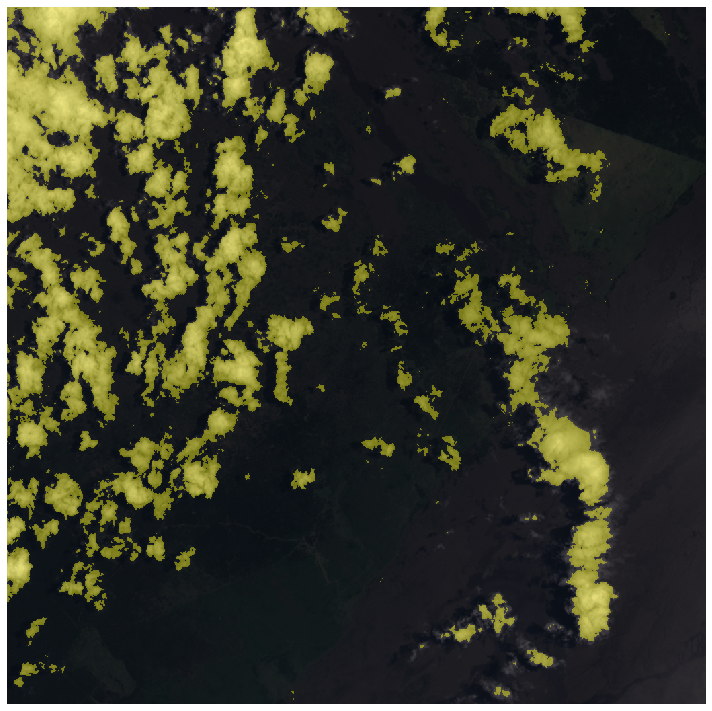

In [2]:
def train_model():
    X = np.load('data.npy')
    y = np.load('targets.npy')
    model = SVC(kernel='rbf', C=1E4, gamma='auto', random_state=31415)
    model.fit(X, y)
    
    gmm = GaussianMixture(num_clusters, covariance_type='full', random_state=31415, n_init=1, max_iter=100,
                          warm_start=True)
    for file_name in next(os.walk(consts.PATH))[1]:
        img_array = tifffile.imread(os.path.join(consts.PATH, file_name, file_name + '.tif'))
        img_gmm = np.transpose(img_array[:4], (1, 2, 0))
        red, green, blue, nir = img_array[:4]
        ndvi = np.divide(np.subtract(nir, red), np.add(nir, red), where=nir!=0)
        img_gmm = np.dstack([img_gmm, ndvi])
        img_flatten = img_gmm.reshape(-1, img_gmm.shape[2])

        clusters = gmm.fit_predict(img_flatten).reshape((img_gmm.shape[0], img_gmm.shape[1]))
        plt.figure(figsize=get_figsize(img_gmm), frameon=False)
        plt.imshow(clusters, cmap=plt.get_cmap('nipy_spectral', num_clusters), aspect='auto')
        plt.tight_layout()
        plt.colorbar()
        plt.axis('off')
        plt.show(block=True)
    
        # Add training data
        targets = input('Enter targets for each cluster, space separated (c/nc)').split()
        if len(targets) == 0:
            break
        X = np.vstack((X, gmm.means_))
        y = np.concatenate((y, targets))
        print(X.shape, y.shape) # The first axes of each array should have the same length
        model.fit(X, y)

    if input('Do you want to save training data (y/n)') == 'y':
        np.save(file='data' + str(datetime.now()), arr=X)
        np.save(file='targets' + str(datetime.now()), arr=y)
        with open('svm.pickle', 'wb') as f:
            pickle.dump(model, file=f, protocol=pickle.HIGHEST_PROTOCOL)

def test_model():
    with open('svm.pickle', 'rb') as f:
        model = pickle.load(file=f)

    gmm = GaussianMixture(num_clusters, covariance_type='full', random_state=31415, n_init=1, max_iter=100,
                          warm_start=True)
    for file_name in next(os.walk(consts.PATH))[1]:
        file_path = os.path.join(consts.PATH, file_name, file_name + '.tif')
        img_array = tifffile.imread(file_path)
        img_gmm = np.transpose(img_array[:4], (1, 2, 0))
        red, green, blue, nir = img_array[:4]
        ndvi = np.divide(np.subtract(nir, red), np.add(nir, red), where=nir!=0)
        img_gmm = np.dstack([img_gmm, ndvi])
        img_flatten = img_gmm.reshape(-1, img_gmm.shape[2])

        clusters = gmm.fit_predict(img_flatten).reshape((img_gmm.shape[0], img_gmm.shape[1]))
        ynew = model.predict(gmm.means_)
        # print(ynew)
        cloud_y = np.where(ynew == 'c')
        cloud_mask = np.isin(clusters, cloud_y)
        
        # generate_shadow_mask(file_path, cloud_mask, [red, green, blue, ndvi])

        # glcm_bands, blue_stats = glcm(file_path)
        # 
        # glcm_mask = np.ma.masked_where(((glcm_bands[27] >= 49) | np.isnan(glcm_bands[27])) & 
        #                                ((glcm_bands[28] >= 3500) | np.isnan(glcm_bands[28])) & 
        #                                ((glcm_bands[38] >= 10000) | np.isnan(glcm_bands[38])) &
        #                                ((glcm_bands[31] <= 79) & (glcm_bands[1] <= 79) & (glcm_bands[11] <= 79) &
        #                                 (glcm_bands[21] <= 79) | np.isnan(glcm_bands[31]) | np.isnan(glcm_bands[1]) |
        #                                 np.isnan(glcm_bands[11]) | np.isnan(glcm_bands[21])), clusters).mask
        final_mask = cloud_mask #& glcm_mask
        # 
        overlay_mask(np.transpose(img_array[:3], (1, 2, 0)), title=f'{file_name} mask', cloud_mask=final_mask)
        # overlay_mask(np.transpose(img_array[:3], (1, 2, 0)), title=f'{file_name} glcm', cloud_mask=glcm_mask)
        # print(f'done {file_name}')
        plt.show(block=True)

test_model()

def generate_shadow_mask(file_path, cloud_mask, img_rgb):
    with open(os.path.splitext(file_path)[0] + '_metadata.json') as metafile:
        metadata = json.load(metafile)
    sky_meta = metadata['Metadata']['SkyWatch_Metadata']
    sun_elev, sun_azim = sky_meta['sun_elevation'], sky_meta['sun_azimuth']
    print(sun_elev, sun_azim)

    # CLOUD SHADOW MASKING (REALLY SLOW, POTENTIAL SPEED UP USING MULTIPROCESSING)
    red, green, blue, ndvi = img_rgb[:4]
    red = red.ravel()
    green = green.ravel()
    blue = blue.ravel()
    ndvi = ndvi.ravel()
    # red < 0.1 and green < 0.1 and blue < 0.1 and ndvi < 0.5
    loose_shadow_mask = np.ma.masked_where((red < 0.1) & (green < 0.1) & (blue < 0.1) & (ndvi < 0.5), red).mask
    loose_shadow_mask = loose_shadow_mask.reshape(cloud_mask.shape)

    def update_shadow_mask(new_i, new_j):
        shadow_mask[new_i, new_j] = True

    def valid_pixel(new_i, new_j):
        if not(0 <= new_i < shadow_mask.shape[0] and 0 <= new_j < shadow_mask.shape[1]):
            return False
        if cloud_mask[new_i, new_j] or shadow_mask[new_i, new_j]:
            return False
        return True

    def handle_bot_left_check(new_i, new_j):
        new_j -= 1
        if not valid_pixel(new_i, new_j):
            return
        point = shape({
            "type": "Point",
            "coordinates": [new_i, new_j]
        })
        if line.contains(point):
            update_shadow_mask(new_i, new_j)
            handle_bot_left_check(new_i, new_j)
        else:
            return

        new_i += 1
        if not valid_pixel(new_i, new_j):
            return
        point = shape({
            "type": "Point",
            "coordinates": [new_i, new_j]
        })
        if line.contains(point):
            update_shadow_mask(new_i, new_j)
            handle_bot_left_check(new_i, new_j)
        else:
            return

        new_j += 1
        if not valid_pixel(new_i, new_j):
            return
        point = shape({
            "type": "Point",
            "coordinates": [new_i, new_j]
        })
        if line.contains(point):
            update_shadow_mask(new_i, new_j)
            handle_bot_left_check(new_i, new_j)
        else:
            return

    def handle_top_left_check(new_i, new_j):
        new_j -= 1
        point = shape({
            "type": "Point",
            "coordinates": [new_i, new_j]
        })
        if line.buffer(buffer).contains(point):
            update_shadow_mask(new_i, new_j)
            handle_top_left_check(new_i, new_j)

        new_i -= 1
        point = shape({
            "type": "Point",
            "coordinates": [new_i, new_j]
        })
        if line.buffer(buffer).contains(point):
            update_shadow_mask(new_i, new_j)
            handle_top_left_check(new_i, new_j)

        new_j += 1
        point = shape({
            "type": "Point",
            "coordinates": [new_i, new_j]
        })
        if line.buffer(buffer).contains(point):
            update_shadow_mask(new_i, new_j)
            handle_top_left_check(new_i, new_j)

    def handle_top_right_check(new_i, new_j):
        new_i -= 1
        point = shape({
            "type": "Point",
            "coordinates": [new_i, new_j]
        })
        if line.buffer(buffer).contains(point):
            update_shadow_mask(new_i, new_j)
            handle_top_right_check(new_i, new_j)

        new_j += 1
        point = shape({
            "type": "Point",
            "coordinates": [new_i, new_j]
        })
        if line.buffer(buffer).contains(point):
            update_shadow_mask(new_i, new_j)
            handle_top_right_check(new_i, new_j)

        new_i += 1
        point = shape({
            "type": "Point",
            "coordinates": [new_i, new_j]
        })
        if line.buffer(buffer).contains(point):
            update_shadow_mask(new_i, new_j)
            handle_top_right_check(new_i, new_j)

    def handle_bot_right_check(new_i, new_j):
        new_j += 1
        point = shape({
            "type": "Point",
            "coordinates": [new_i, new_j]
        })
        if line.buffer(buffer).contains(point):
            update_shadow_mask(new_i, new_j)
            handle_bot_right_check(new_i, new_j)

        new_i += 1
        point = shape({
            "type": "Point",
            "coordinates": [new_i, new_j]
        })
        if line.buffer(buffer).contains(point):
            update_shadow_mask(new_i, new_j)
            handle_bot_right_check(new_i, new_j)

        new_j -= 1
        point = shape({
            "type": "Point",
            "coordinates": [new_i, new_j]
        })
        if line.buffer(buffer).contains(point):
            update_shadow_mask(new_i, new_j)
            handle_bot_right_check(new_i, new_j)

    buffer = 5
    theta_prime = math.radians(sun_azim + 90.0)
    r = math.hypot(cloud_mask.shape[0], cloud_mask.shape[1]) / 32.0
    shadow_mask = np.full(cloud_mask.shape, False)

    if 0.0 <= sun_azim <= 90.0:
        # check left, bottom-left and bottom indices
        check = handle_bot_left_check
    elif 90.0 < sun_azim <= 180.0:
        # check left, top-left and top indices
        check = handle_top_left_check
    elif 180.0 < sun_azim <= 270.0:
        # check top, top-right and right indices
        check = handle_top_right_check
    elif 270.0 < sun_azim <= 360.0:
        # check right, bottom-right and bottom indices
        check = handle_bot_right_check
    else:
        raise RuntimeError(f'improper sun_azim={sun_azim}')

    print(cloud_mask.shape)
    for i in range(len(cloud_mask)):
        for j in range(len(cloud_mask[i])):
            if cloud_mask[i,j]:
                # recurse 
                # check 3 adjacent indices unless already identified as cloud shadow, based on angle
                line = shape({
                    "type": "LineString",
                    "coordinates": [[i,j], [math.ceil(i + r * math.sin(theta_prime)),
                                            math.ceil(j + r * math.cos(theta_prime))]]
                }).buffer(buffer)

                check(i, j)
        print(i)

    final_shadow_mask = np.ma.masked_where(shadow_mask & loose_shadow_mask, shadow_mask).mask

    overlay_mask(img_rgb, cloud_mask=cloud_mask, shadow_mask=final_shadow_mask, figsize=get_figsize(img_rgb))